In [2]:
import matplotlib.pyplot as plt
from math import cos, sin
from numpy import pi
import numpy as np

In [91]:
"""
Our goal is to create a function that can generate values that follow a sinusoidal curve. 
Below, we graph that curve
"""
pass

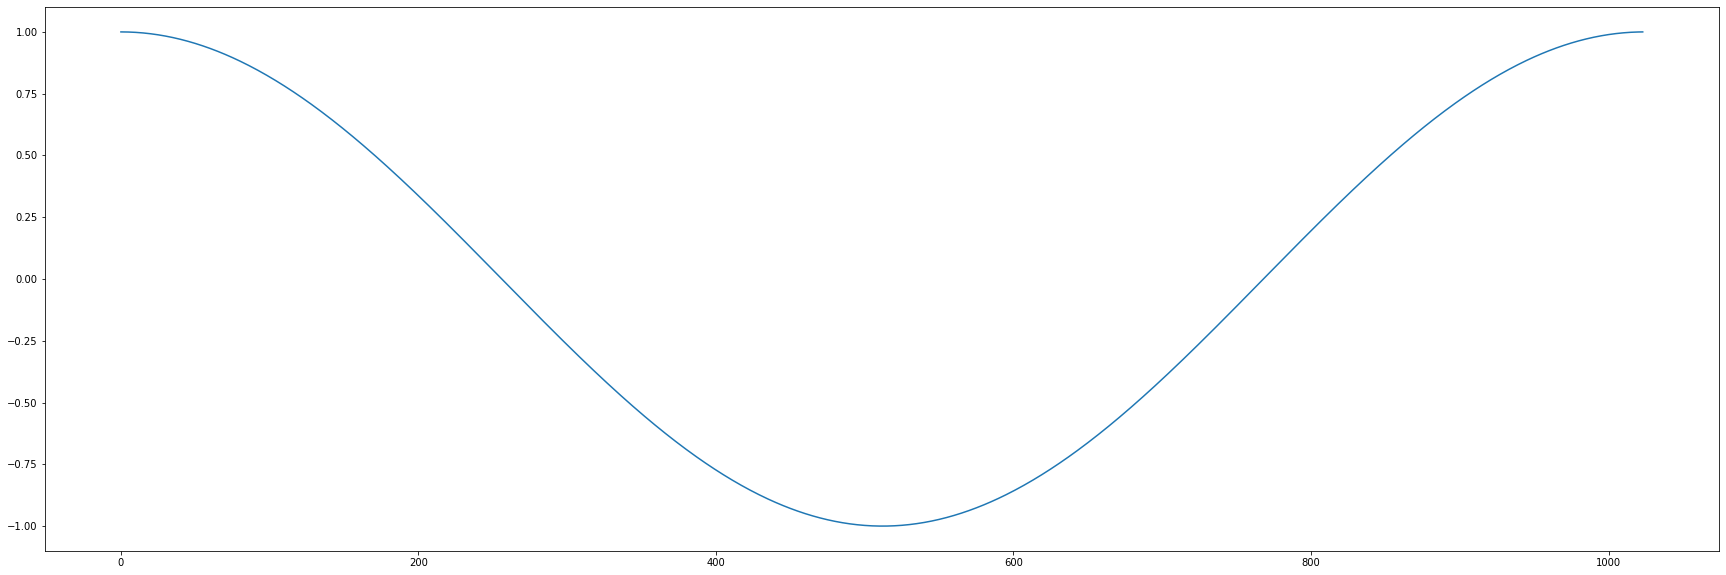

In [4]:
plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(1024)])
plt.show()

In [5]:
"""
We will use a first order Taylor series approximation to get something that looks somewhat sinusoidal. 
The Taylor series for cosine is only accurate up to x = pi/2, so lets zoom in on that part of the graph.
"""
pass

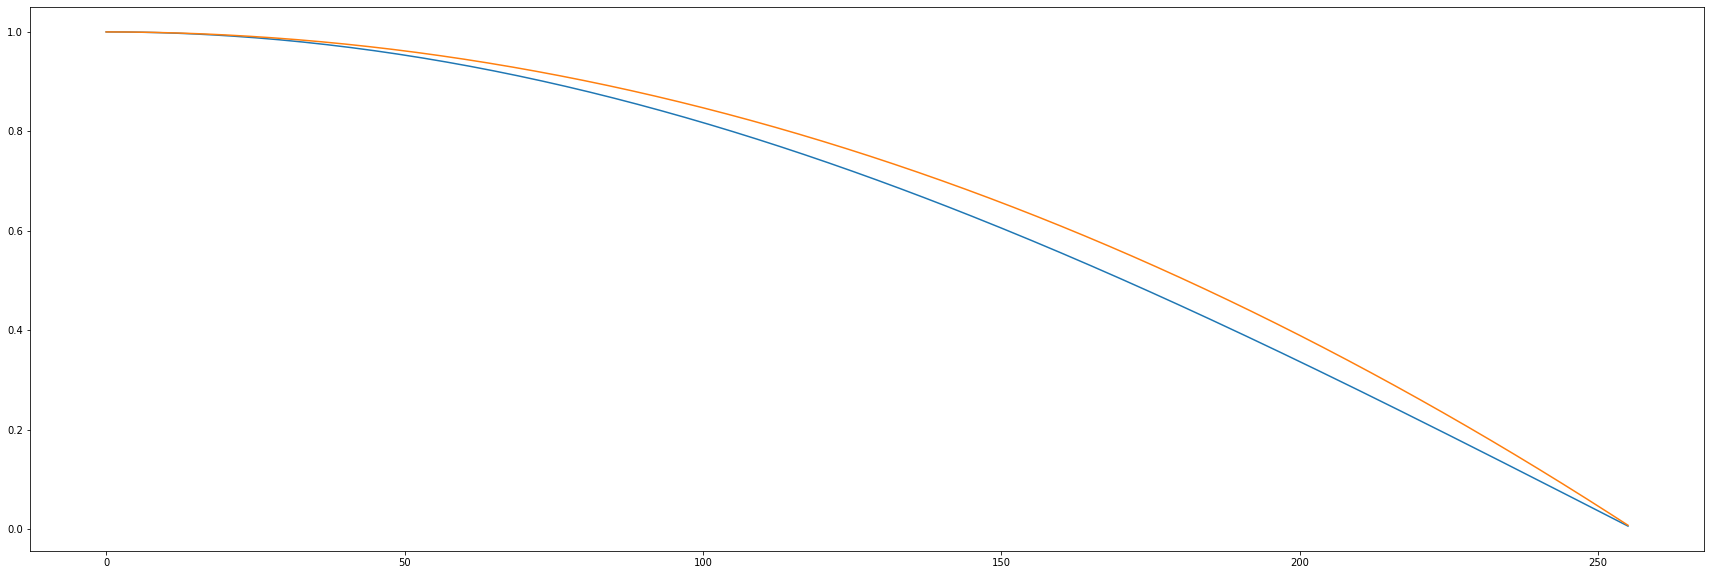

In [6]:
plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(256)]) # blue
plt.plot([1 - (x/256)**2 for x in range(256)])     # orange
plt.show()

In [9]:
"""
We need to concatenate four different translations and transpositions of the x^2 function to 
eventually approximate the full cosine function
"""
pass

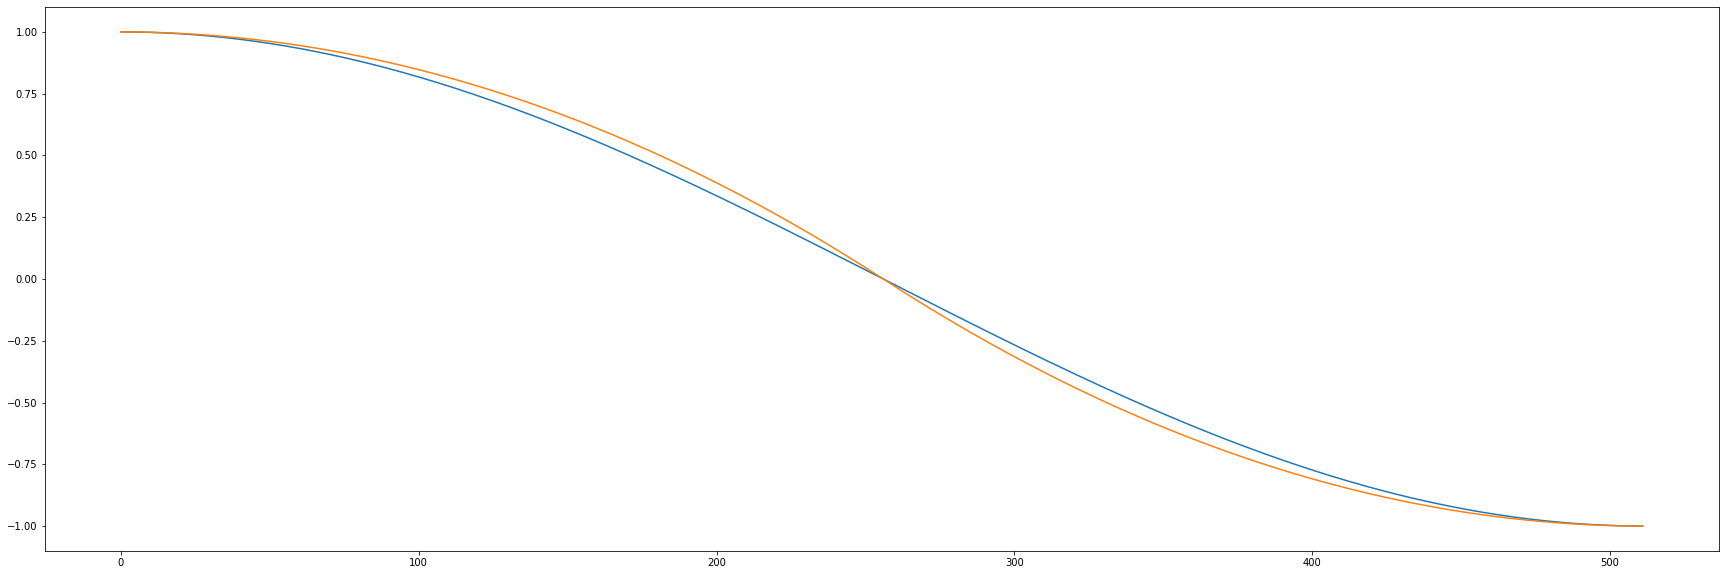

In [10]:
plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(512)]) # blue
plt.plot(
    [1 - (x/256)**2 for x in range(256)] + # 1 - x^2
    [(1 - x/256)**2 - 1 for x in range(256)] # (1 - x)^2 - 1 = 1 - 2x + x^2 - 1 = s^2 - 2x
)     # orange
plt.show()

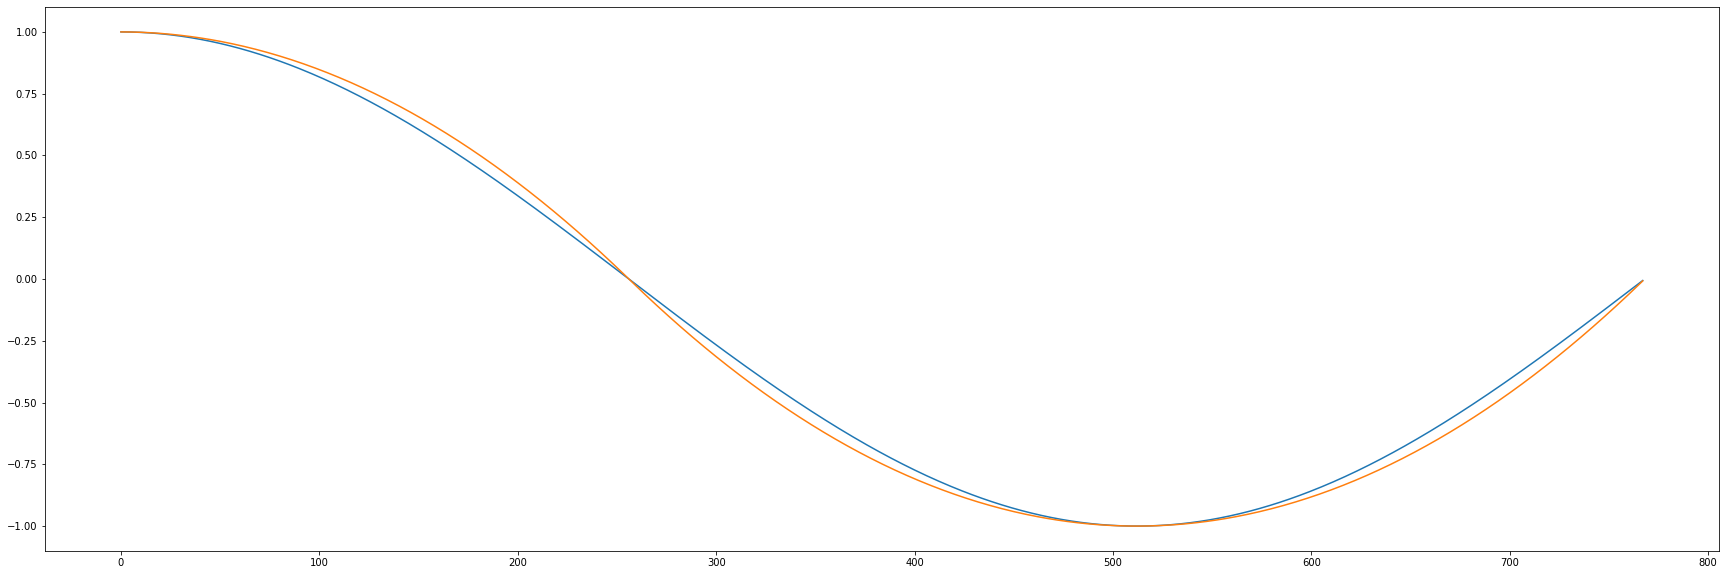

In [11]:
plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(768)]) # blue
plt.plot(
    [1 - (x/256)**2 for x in range(256)] + # 1 - x^2
    [(1 - x/256)**2 - 1 for x in range(256)] + # (1 - x)^2 - 1 = 1 - 2x + x^2 - 1 = s^2 - 2x
    [(x/256)**2 - 1 for x in range(256)] # x^2 - 1
)     # orange
plt.show()

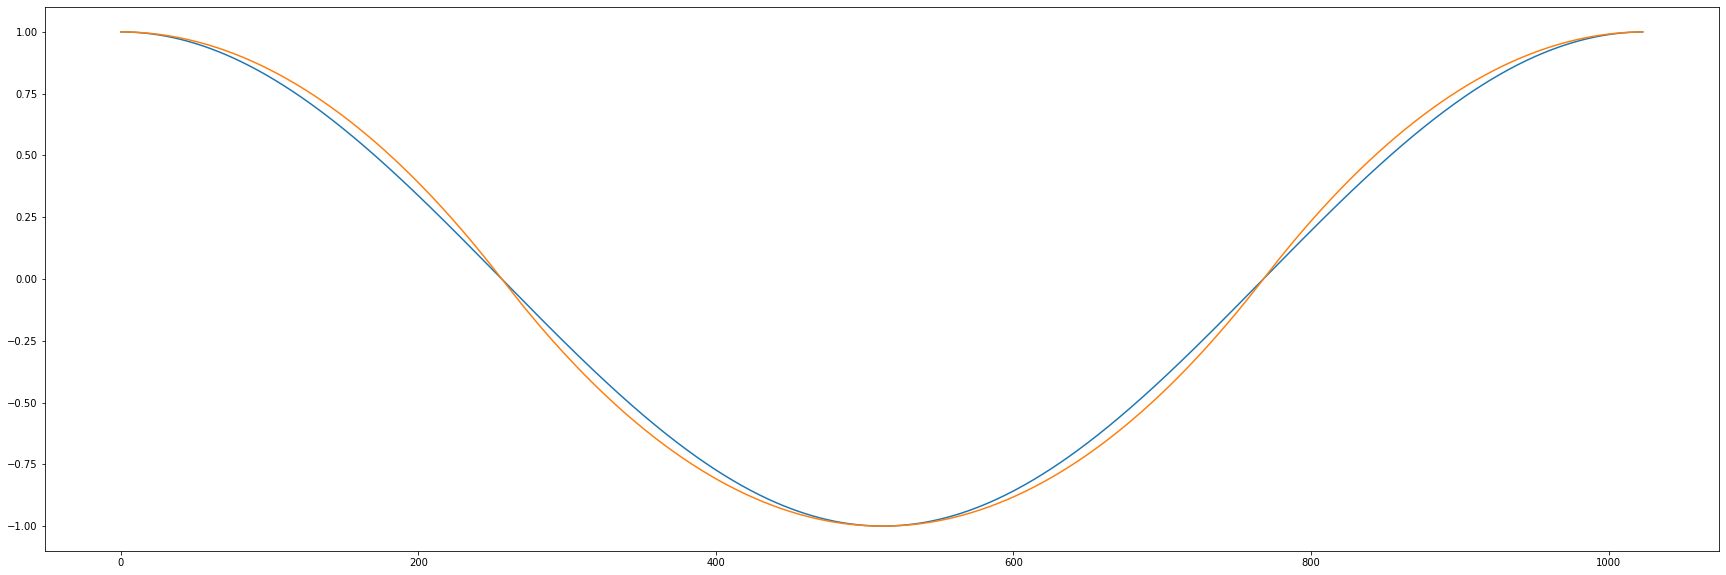

In [12]:
plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(1024)]) # blue
plt.plot(
    [1 - (x/256)**2 for x in range(256)] + # 1 - x^2
    [(1 - x/256)**2 - 1 for x in range(256)] + # (1 - x)^2 - 1 = 1 - 2x + x^2 - 1 = x^2 - 2x
    [(x/256)**2 - 1 for x in range(256)] + # x^2 - 1
    [1 - (1 - x/256)**2 for x in range(256)] # 1 - (1 - x^2) = 1 - (1 - 2x + x^2) = 2x - x^2
)     # orange
plt.show()

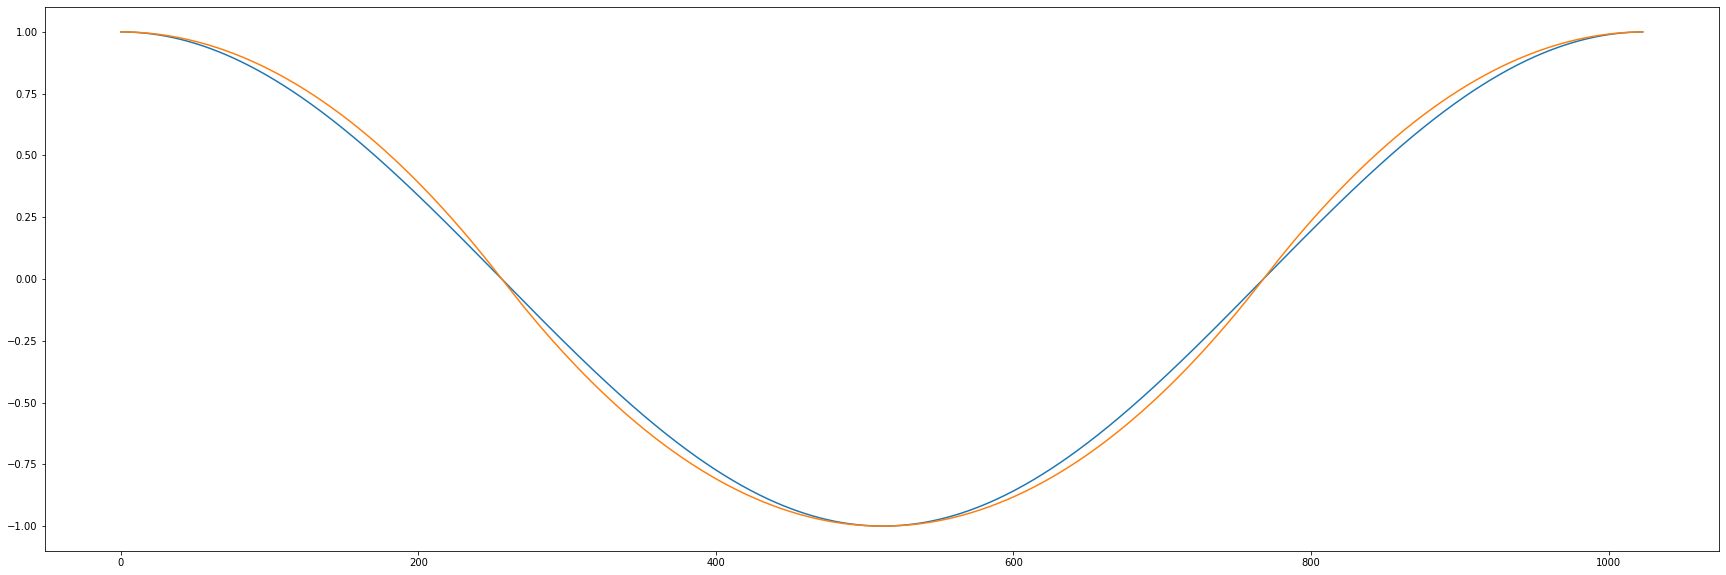

In [13]:
"""
So at this point, we can approximate a full cycle of the cosine function.
Based on which quarter cycle we are in, we have to do a different translation to the x^2 function:

ax^2 + bx + c

Q   a  b  c
1: -1  0  1
2:  1 -2  0
3:  1  0 -1
4: -1  2  0

"""

plt.figure(figsize=(30,10))
plt.plot([cos((x*2*pi)/1024) for x in range(1024)]) # blue

coefs = [[-1, 0, 1], [1, -2, 0], [1, 0, -1], [-1, 2, 0]]
approx = []

for q in range(4):
    for x in range(256):
        approx.append(coefs[q][0] * (x/256)**2 + coefs[q][1] * (x/256) + coefs[q][2])
        
plt.plot(approx)
plt.show()

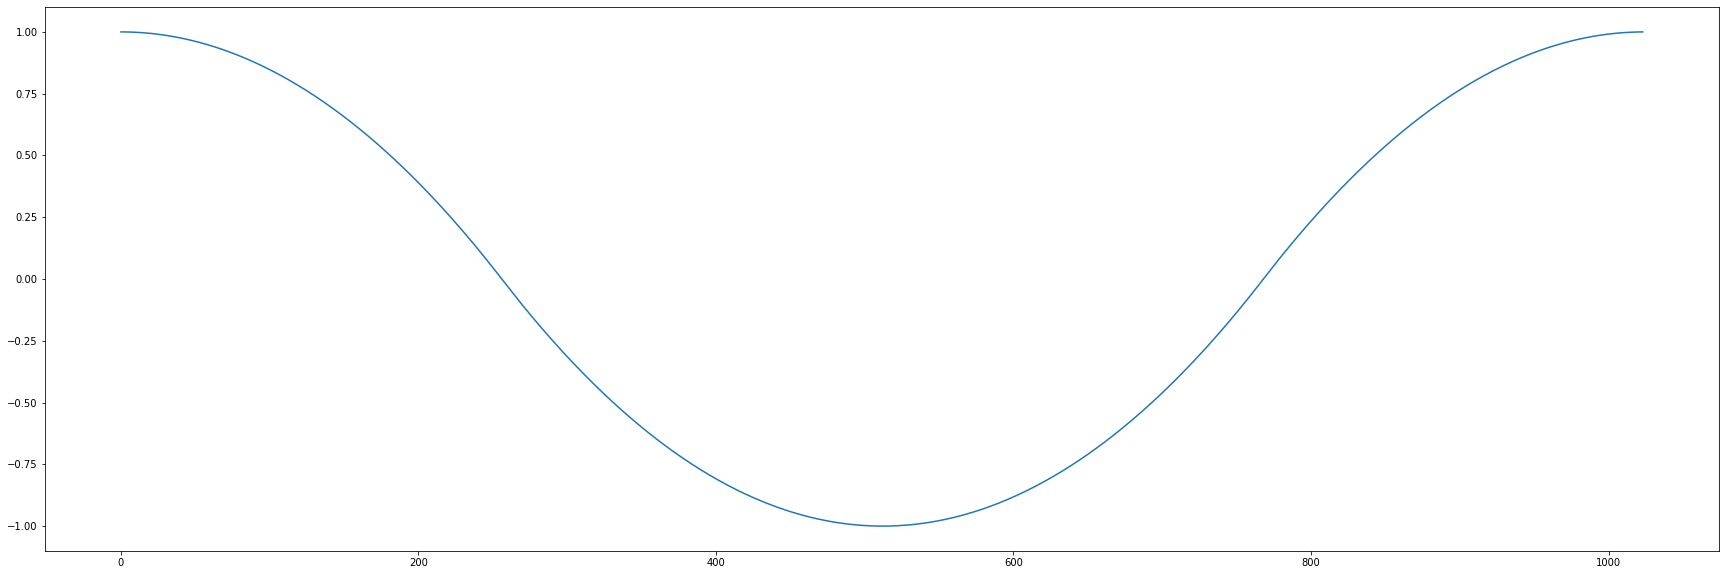

In [15]:
"""
Now, we want to generate this just a little bit faster. 
The first thing we do is restrict the period to some power of two for easier calculations.

In this case, let's use 1024 = 2^10.
Then, based on which quarter of a period we're in, we want to use the proper coefficients of 
our quadratic approximation. 

We can figure out which quarter of a period we are in by taking the 
leftmost two bits of our 10 bit input
"""

def wave_1(x): #x is our input, in the range [0,1024)
    qp = x>>8 # qp stands for quarter period, going to be in the range [0,4)
    coefs = [[-1, 0, 1], [1, -2, 0], [1, 0, -1], [-1, 2, 0]]
    fraction = (x%256)/256
    return (coefs[qp][0] * fraction**2) + ((coefs[qp][1]) * fraction) + coefs[qp][2]


plt.figure(figsize=(30,10))
plt.plot([wave_1(x) for x in range(1024)])
plt.show()

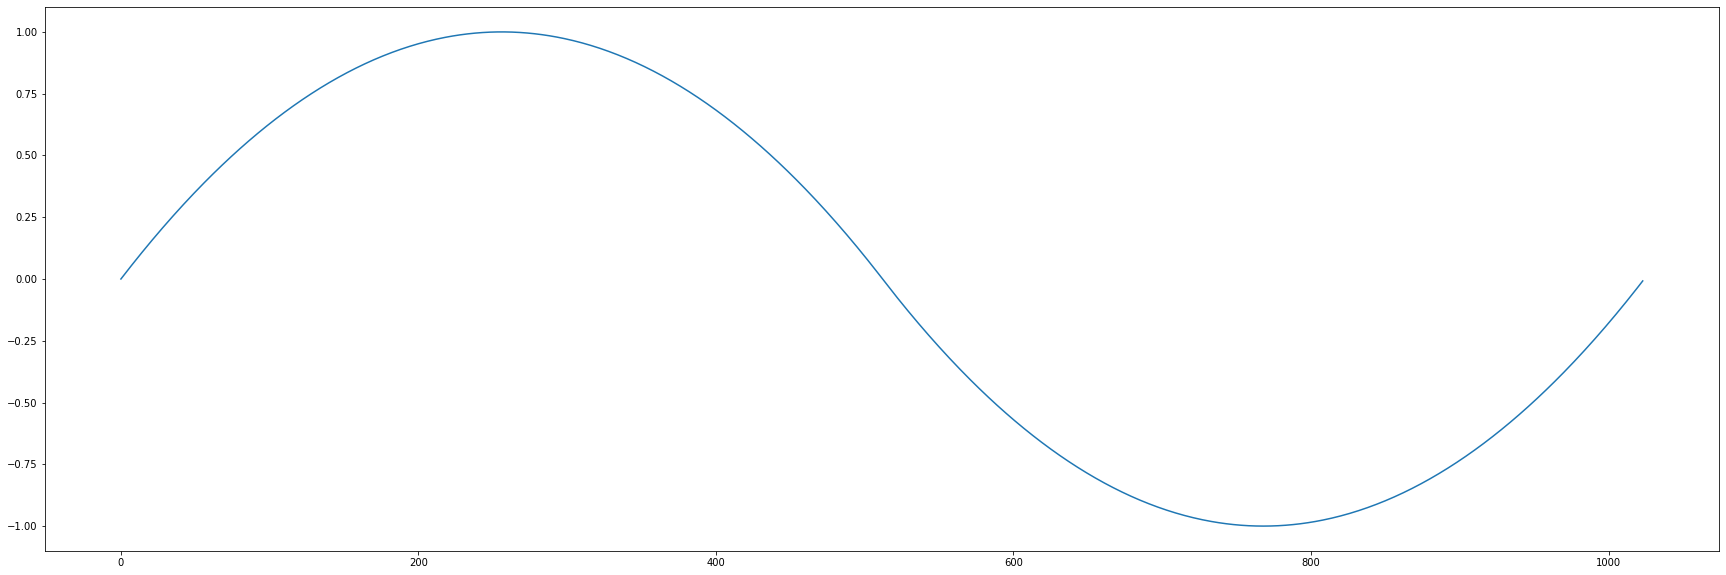

In [16]:
"""
Note that if we rotate the coefficient matrix, we still get a sinusoidal wave
"""

def wave_2(x): #x is our input, in the range [0,1024)
    qp = x>>8 # qp stands for quarter period, going to be in the range [0,4)
    coefs = [[-1, 2, 0], [-1, 0, 1], [1, -2, 0], [1, 0, -1]]
    fraction = (x%256)/256
    return (coefs[qp][0] * fraction**2) + ((coefs[qp][1]) * fraction) + coefs[qp][2]


plt.figure(figsize=(30,10))
plt.plot([wave_2(x) for x in range(1024)])
plt.show()

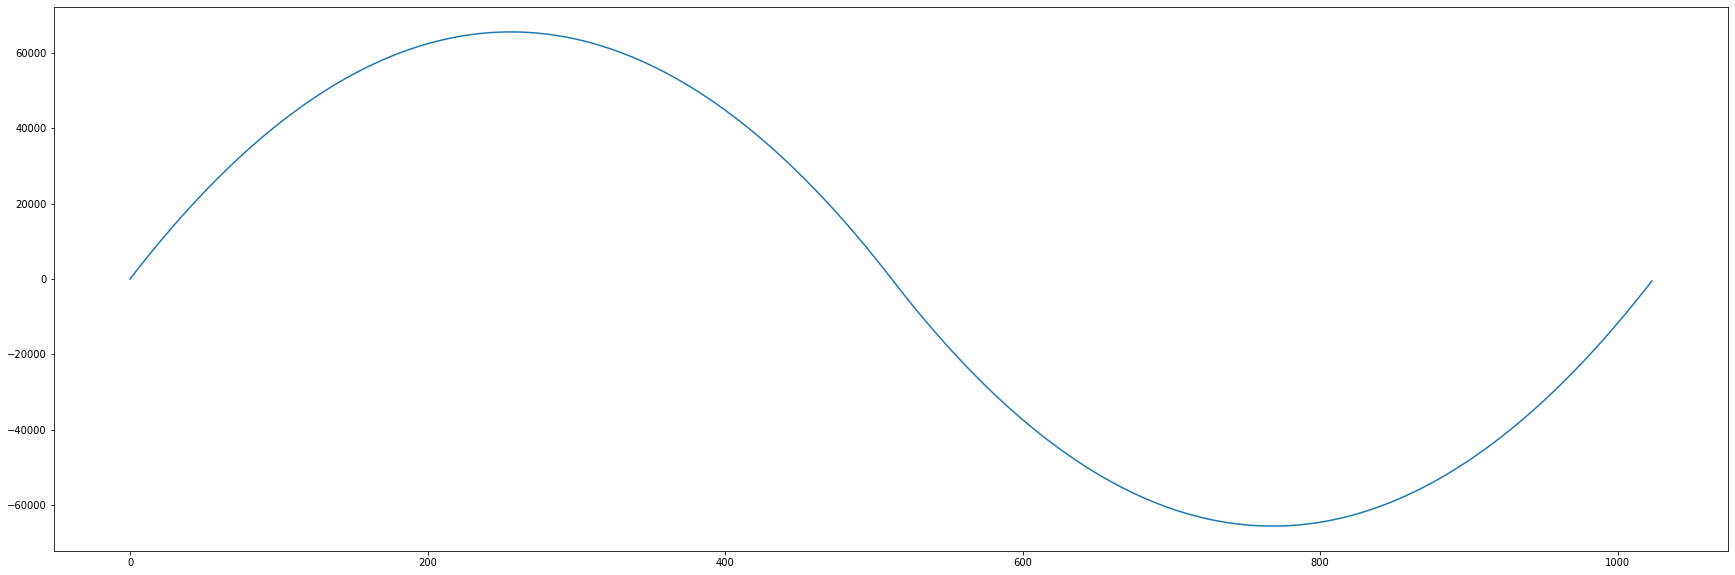

In [17]:
"""
On most architectures (especially small RISC architectures like AVR), floating point division is really slow.
We can mitigate this problem by just scaling up the output from the range [-1,1] to a large power of 2.

In this case, as we are doing x/256 (note 256 = 2^8), if we multiply everything by 2^16, 
the denominators cancel out

Note that the shape of the graph is the exact same
"""

def wave_3(x): #x is our input, in the range [0,1024)
    qp = x>>8 # qp stands for quarter period, going to be in the range [0,4)
    coefs = [[-1, 2, 0], [-1, 0, 1], [1, -2, 0], [1, 0, -1]]
#     fraction = (x%256)/256
#     return (coefs[qp][0] * fraction**2) + ((coefs[qp][1]) * fraction) + coefs[qp][2]
    value = (x%256)
    return (coefs[qp][0] * value**2) + ((coefs[qp][1]) * value * 256) + (coefs[qp][2] * (256**2))


plt.figure(figsize=(30,10))
plt.plot([wave_3(x) for x in range(1024)])
plt.show()

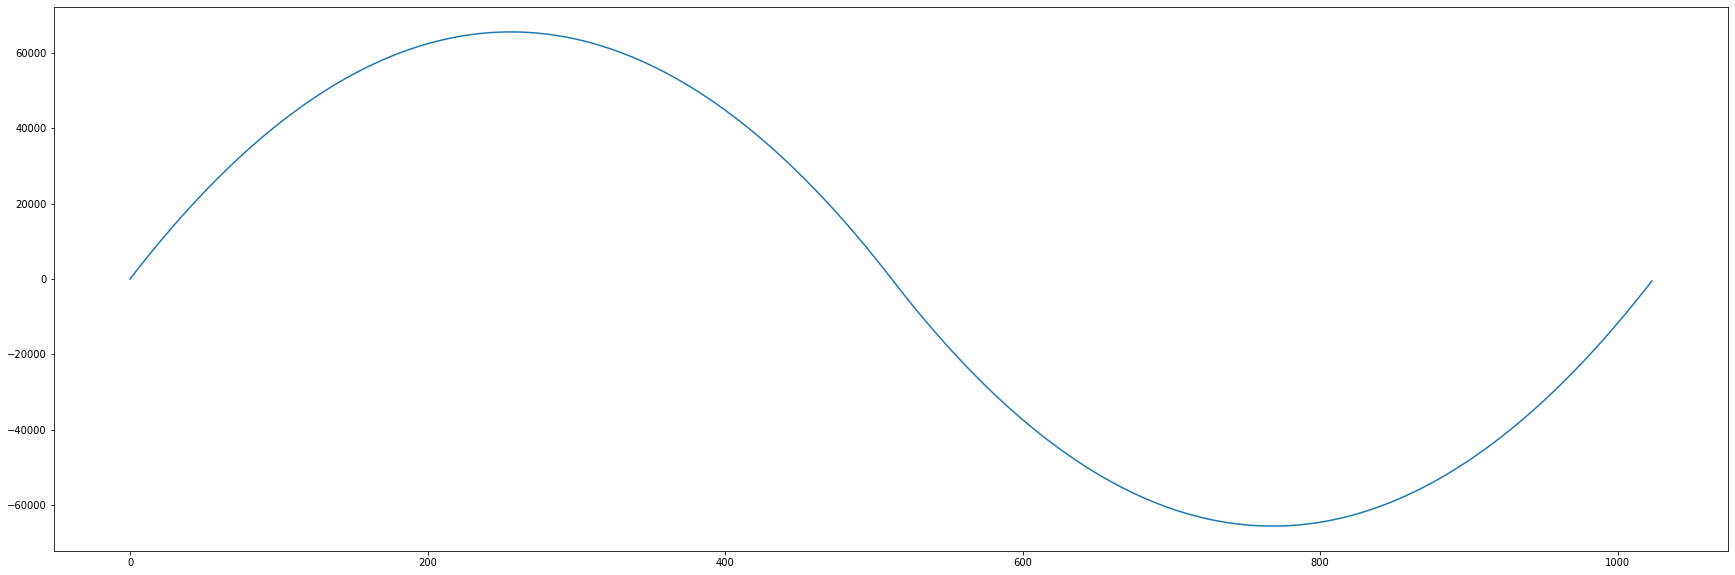

In [18]:
"""
We can obfuscate the coefficient matrix by making the a, b, and c values a function of the qp value:

qp:  a  b  c
00  -1  2  0
01  -1  0  1
10   1 -2  0
11   1  0 -1

Let lb represent the left bit of qp, and rb represent the right bit of qp

we have: 
a = 2*lb - 1
    when lb is 0, we get -1, otherwise we get 1
b = (2 - 4*lb) * (1 - rb) 
    when rb is 1, we get 0, when lb,rb = 0,0 we get 2, otherwise we get (2 - 4) * 1 = -2 when lb,rb = 1,0
c = (1 - 2*lb) * (rb)
    when rb is 0, we get 0, when lb,rb = 0,1 we get 1, otherwise we get (1 - 2) * 1 = -1 when lb,rb = 1,1 
"""

def wave_4(x): #x is our input, in the range [0,1024)
    qp = x>>8 
    lb = qp >> 1
    rb = qp & 1
    a = 2*lb - 1
    b = (2 - 4*lb) * (1 - rb)
    c = (1 - 2*lb) * (rb)
    value = (x%256)
    return (a * value**2) + (b * value * 256) + (c * (256**2))


plt.figure(figsize=(30,10))
plt.plot([wave_4(x) for x in range(1024)])
plt.show()

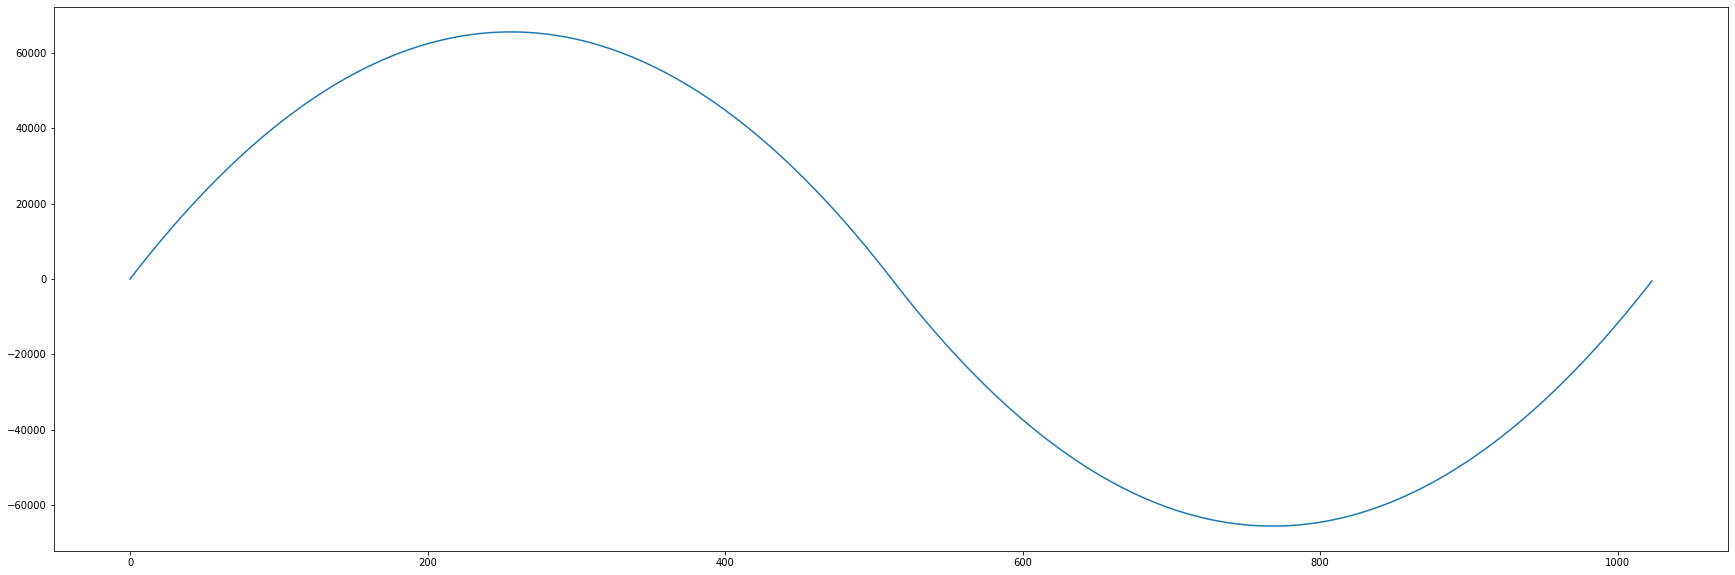

In [19]:
"""
Let us condense our code just a bit further. Also, note that doing 2 - 4*lb, for example, 
must be implemented as (-4 * lb - 1)
We can obfuscate the coefficient matrix by making the a, b, and c values a function of the qp value:

qp:  a  b  c
00  -1  2  0
01  -1  0  1
10   1 -2  0
11   1  0 -1

Let lb represent the left bit of qp, and rb represent the right bit of qp

we have: 
a = 2*lb - 1
b = (2 - 4*lb) * (1 - rb) = 2 - 2rb - 4lb + 4lbrb = 2 (1 - rb - 2lb + 2lbrb) = 2 * (2lb - 1) * (rb - 1)
c = (1 - 2*lb) * (rb) = rb - 2lbrb = rb (1 - 2lb) = -rb * (2lb - 1)

And thus our final equation is:

return 
    (a * X * X) + (b * X * 256) + (c * 256 * 256) = 
    (a * X + b * 256) * X + (c * 256 * 256)
    

substituting values gets us:

    (((2lb - 1)X + (2 * (2lb - 1) * (rb - 1)) * 256) * X + ((2lb - 1) * (-rb) * 256 * 256)) = 
    (2lb - 1) (((X + (2 * (rb - 1) * 256)) * X + ((-rb) * 256 * 256))) = 
    (2lb - 1) (((X + 512rb - 512)*X) - 256*256*rb)
"""

def wave_5(x): #x is our input, in the range [0,1024)
    qp = x>>8 
    lb = qp >> 1
    rb = qp & 1
    tlbm1 = 2*lb - 1
    X = (x%256)
    return tlbm1 * ((X + 512 * rb - 512)*X - (256 * 256 * rb))


plt.figure(figsize=(30,10))
plt.plot([wave_5(x) for x in range(1024)])
plt.show()

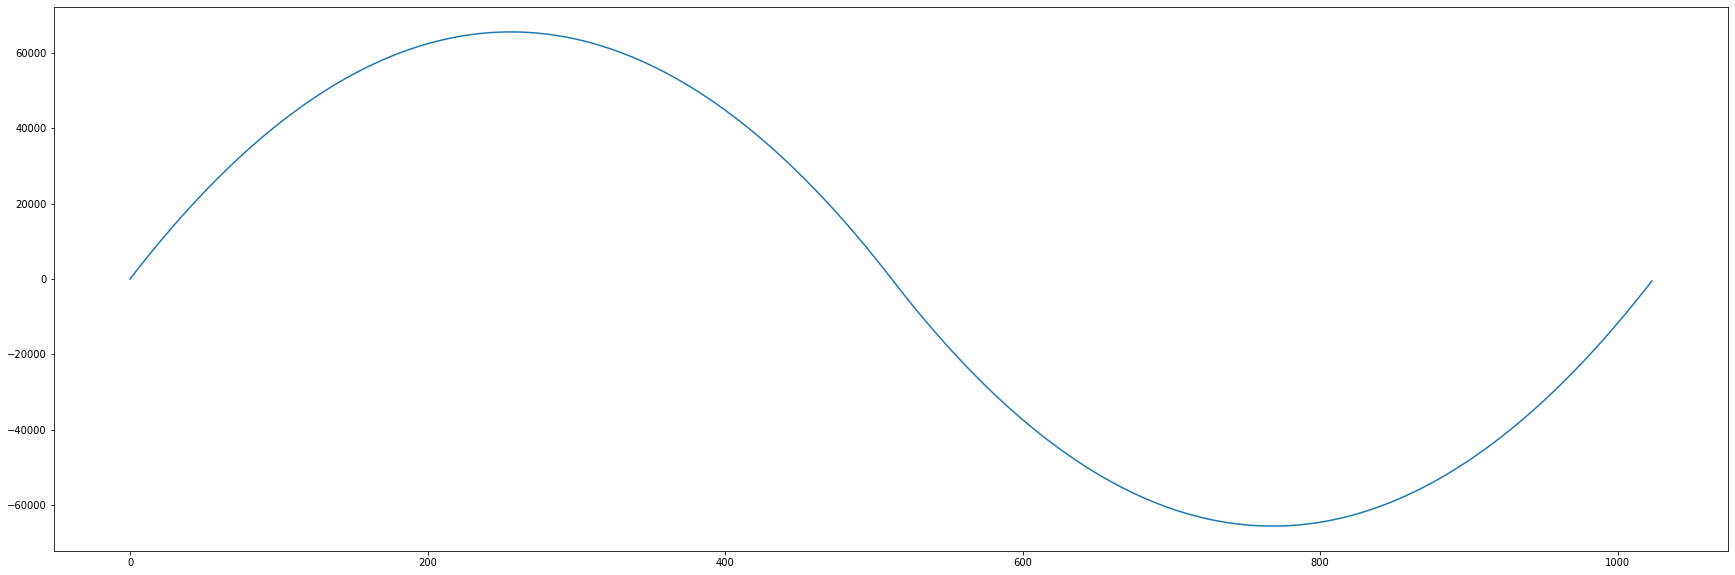

In [20]:
"""
We can actually make this even more efficient by calculating 2lb faster: instead of doing (qp >> 1) * 2, 
which is the same as (qp >> 1) << 1, we can just zero out the rightmost bit by doing (qp & 2)

Further note that rb is always multiplied by at least 512, so we can take care of that in our calculation for rb

Note that modulus a power of two is the same thing as taking only a few of the least significant n bits;
    thus, X = x%256 (which is a slow operation) can be replaced with X = x & (256 - 1)
    
Also, as we are doing rb = (qp & 1) << 9, we get rb = ((x >> 8) & 1) << 9

Lastly, we can replace any integer multiplication operation with a power of two with a left shift
"""

def wave_6(x): #x is our input, in the range [0,1024)
    qp = x>>8 
    tlbm1 = (qp & 2) - 1
    rb = (qp & 1) << 9
    X = x & 255
#   return tlbm1 * ((X + 512 * rb - 512)*X - (256 * 256 * rb))
    return tlbm1 * ((X + rb - 512)*X - (rb << 7))


plt.figure(figsize=(30,10))
plt.plot([wave_6(x) for x in range(1024)])
plt.show()

In [21]:
"""
Finally, we have been hardcoding in values for a period of 1024, but we can actually generalize this
to any precision we want, and it's all done in 12 instructions. Furthermore, we use no floating
point operations, and no division (floating point or integer).

And finally, for maximum obfuscation, we strip all variable names of any meaning.
"""

def generate_func(l2p): #l2p = log_2(period)
    return """
    a = x >> {}
    b = (a & 2) - 1
    c = (a & 1) << {}
    d = x & {}
    return b * (((d + c - {}))*d - (c << {}))
    """.format(l2p - 2, l2p - 1, (1 << (l2p - 2)) - 1, 1 << (l2p - 1), l2p - 3)

print(generate_func(10))


    a = x >> 8
    b = (a & 2) - 1
    c = (a & 1) << 9
    d = x & 255
    return b * (((d + c - 512))*d - (c << 7))
    


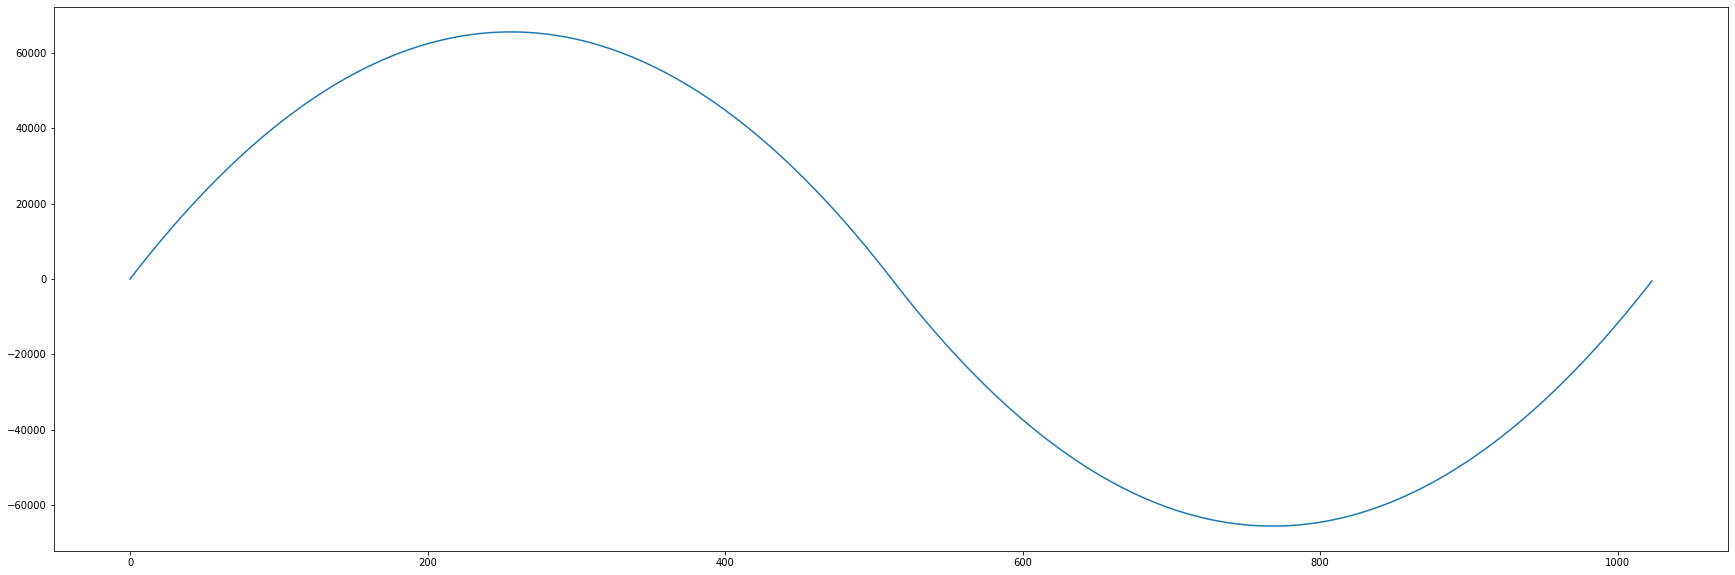

65536


In [3]:
def wave_7(x):
    a = x >> 8
    b = (a & 2) - 1
    c = (a & 1) << 9
    d = x & 255
    return b * (((d + c - 512))*d - (c << 7))

plt.figure(figsize=(30,10))
vals = [wave_7(x) for x in range(1 << 10)]
plt.plot(vals)
plt.show()
print(max(vals))

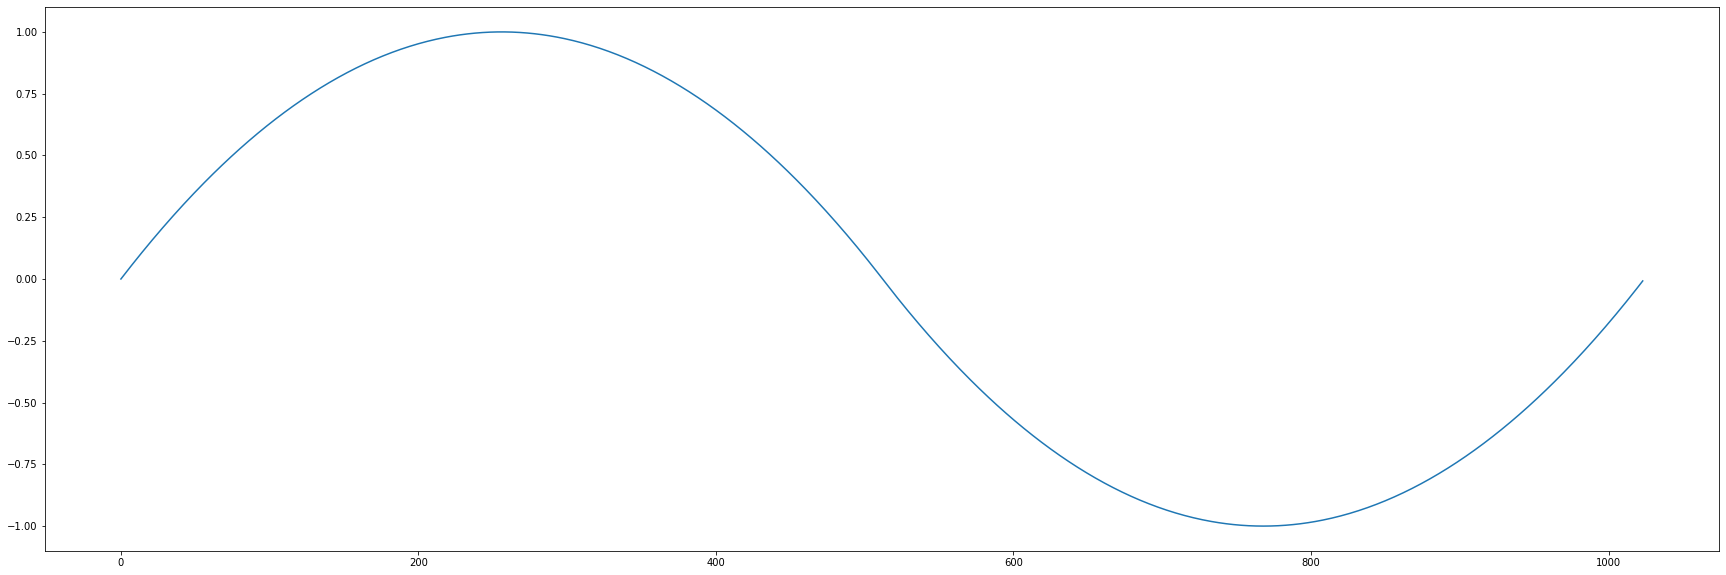

In [31]:
plt.figure(figsize=(30,10))
plt.plot([-((x-256)/256)**2 + 1 for x in range(512)] + [((x-256)/256)**2 - 1for x in range(512)])

plt.show()

In [67]:
def gen_code_2(l2p):
    return """
    t = x & {}
    return (((((x >> {}) & 2) - 1)) * t * (t - {}))
    """.format((1<<(l2p-1)) - 1, l2p - 2, 1<<(l2p-1))

In [10]:
wave_8(1024)

0

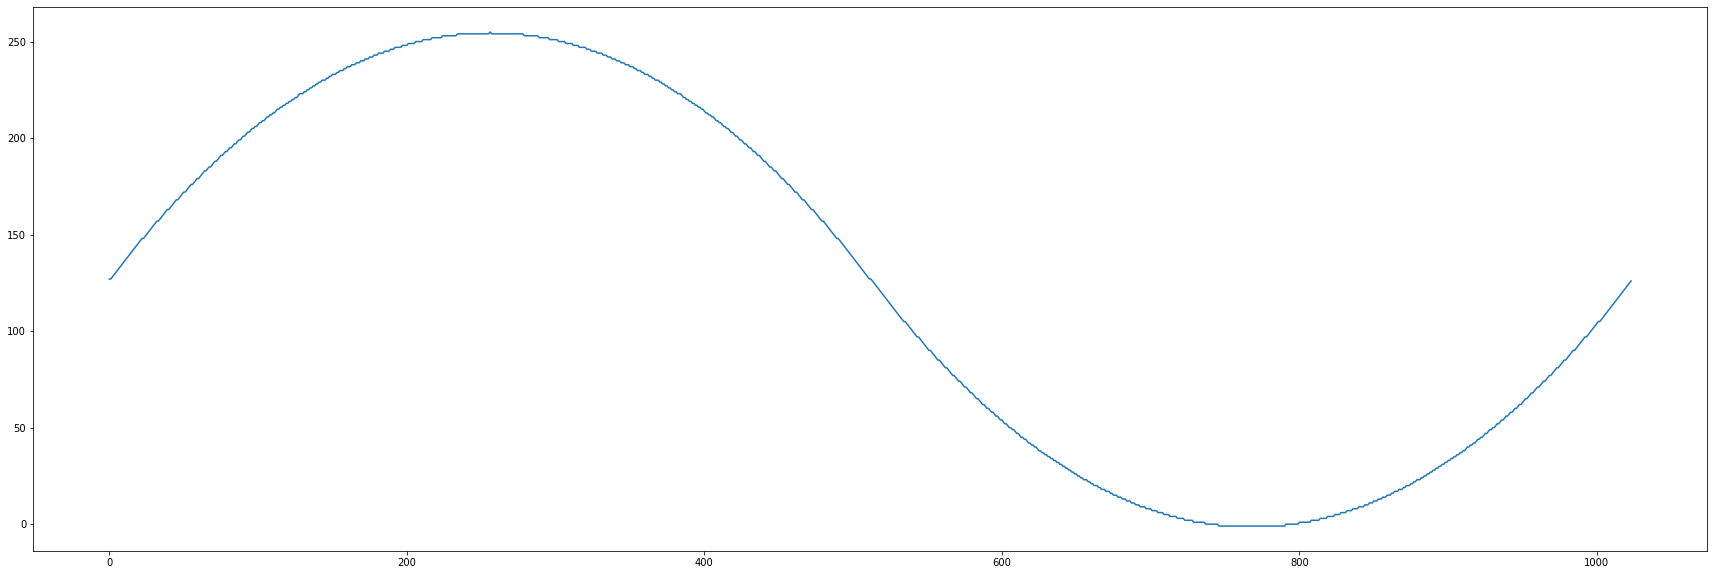

In [27]:
# 7 instructions
def wave_8(x): 
    sign = ((((x >> 9) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = x & 1023
    return (sign * t * (t - 1024)) #either 512x - x^2 or x^2 - 512x

def wave_9(x): 
    sign = ((((x >> 7) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = x & 255
    return (sign * t * (t - 256)) #either 512x - x^2 or x^2 - 512x

def wave_10(x): 
    sign = ((((x >> 8) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = x & 511
    return ((sign * t * (t - 512))>>9) + 127

plt.figure(figsize = (30,10))
plt.plot([wave_10(x) for x in range(1<<10)])
# plt.plot([sin(x * 2 * pi/(1<<11)) for x in range(1<<11)])
plt.show()

# err = np.asarray([(wave_8(x)/(1<<18) - sin(x * 2 * pi/(1<<11))) for x in range(1<<11)])
# plt.plot(err)
# plt.show()

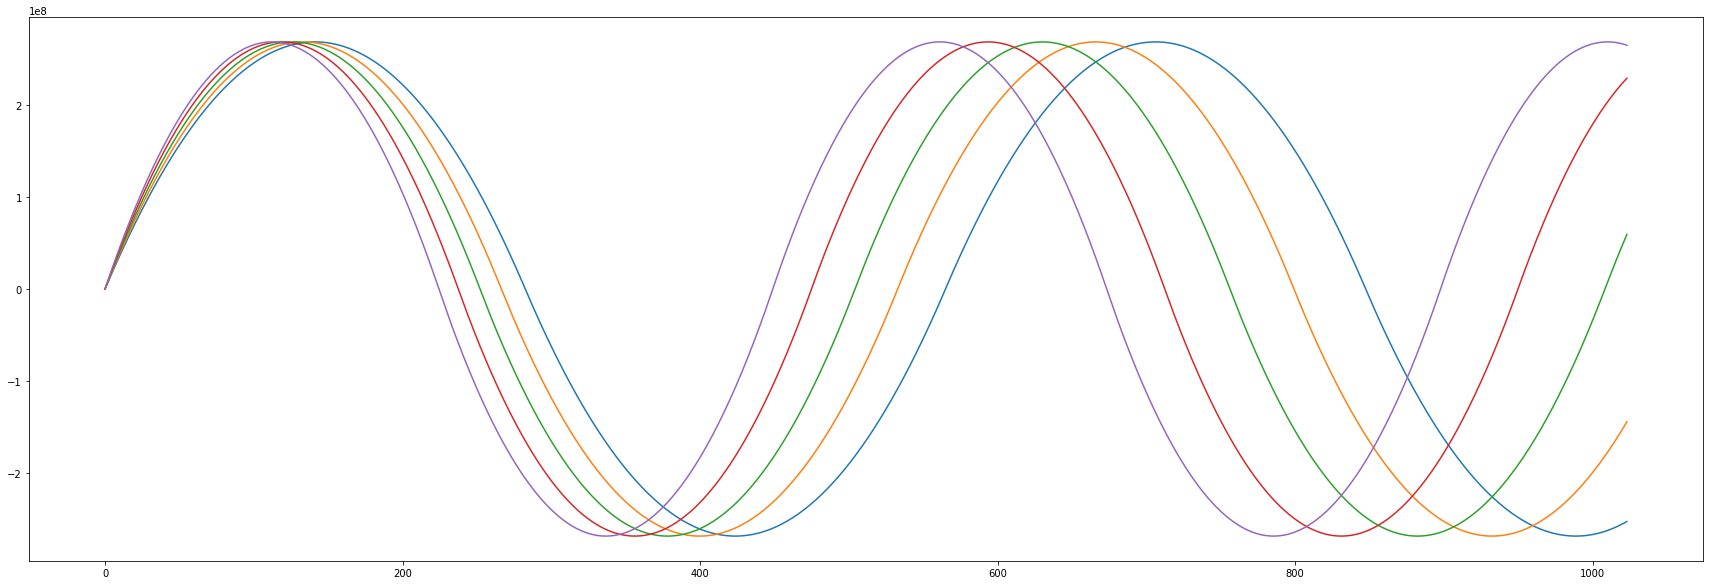

In [124]:
plt.figure(figsize=(30,10))
plt.plot([wave_10(116*x) for x in range(1<<10)])
plt.plot([wave_10(123*x) for x in range(1<<10)])
plt.plot([wave_10(130*x) for x in range(1<<10)])
plt.plot([wave_10(138*x) for x in range(1<<10)])
plt.plot([wave_10(146*x) for x in range(1<<10)])
# plt.plot([wave_10(116*x) for x in range(1<<10)])
# plt.plot([wave_10(116*x) for x in range(1<<10)])
# plt.plot([wave_10(116*x) for x in range(1<<10)])

plt.show()

In [125]:
ratios = 116, 123, 130, 138, 146, 155, 164, 174, 184, 195, 207, 219;

In [ ]:
[0, 255] -> [-128, 127]

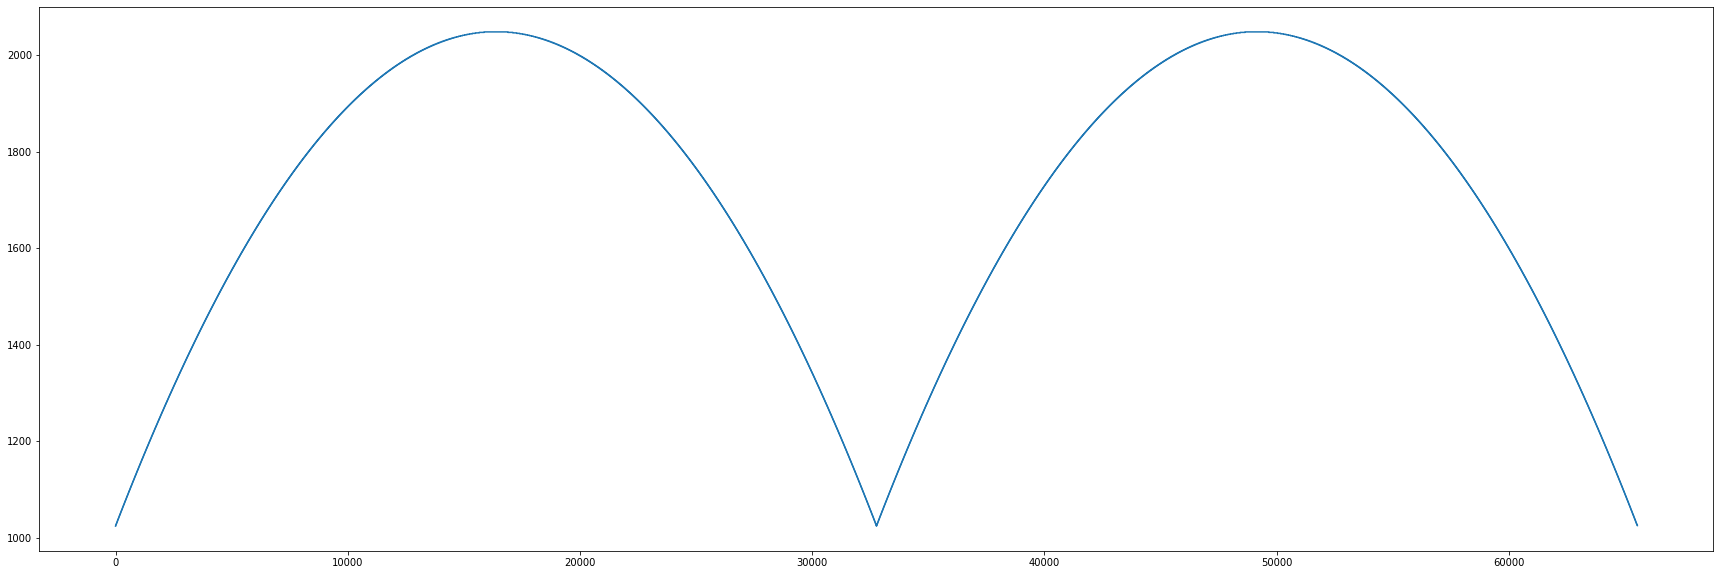

In [234]:
def wave_16(x): 
    sign = ((((x >> 14) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = x & 32767
    return (sign * t * (t - 32768)) #either 512x - x^2 or x^2 - 512x

def norm_wav_16(x):
    sign = ((x >> 14) & 2) - 1 #if x is in the first half, sign = -1, else sign = 1
    t = x & 32767
    return (sign * t * (t - 32768)) >> 18

    # >> 18  
#     t1 = (x & 65535) 
#     - 32768
#     t2 = (x & 32767) - 32768
#     return (t1 * t2)

plt.figure(figsize=(30,10))
plt.plot([norm_wav_16(x) for x in range(1<<16)])

# plt.plot([wave_16(x) for x in range(1<<12)])

plt.show()

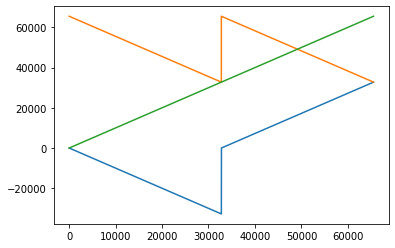

In [213]:
def sign(x):
    sign = ((((x >> 14) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = (x & 32767)
    return sign * t

def sign2(x):
    t = (x & 32767)
    return 65536 - t

plt.plot([sign(x) for x in range(1<<16)])
plt.plot([sign2(x) for x in range(1<<16)])
plt.plot([x for x in range(1<<16)])
plt.show()

In [190]:
wave_16((1<<14)) == (1<<28)# 268435456

True

In [151]:
magnitudes = [0,0,0,0,0]
# We need to decode a integer into five integers


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

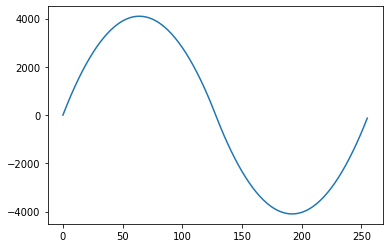

In [158]:
def wav_8(x):
    sign = ((((x >> 6) & 2) - 1)) #if x is in the first half, sign = -1, else sign = 1
    t = x & 127
    return (sign * t * (t - 128))>>

plt.plot([wav_8(x) for x in range(1<<8)])
plt.show()